<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# kNN Classification Exercise

For this exercise, we'll use water pump data from DrivenData.org

Your goal is to predict the operating condition of a waterpoint for each record in the dataset.

It is a multiclass classification problem with `status_group` as the target class.

Take some time to read the data dictionary here: [https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25)

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("../assets/data/water_pumps.csv.gz")

#### 1: There are a lot of columns, so instead of performing the usual EDA on *all* columns, choose 3-4 columns to focus on and explore the data checking for (among other things):

- missing values
- strange values
- distributions and relationships in your data

In [2]:
df.shape

(59400, 41)

In [3]:
df.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Information about funding and installation is occasionally missing. Most values are intact.

We'll take population, source of water, water quality and "amount".

In [4]:
columns_of_interest = ["population", "source", "water_quality", "amount_tsh"]
df[columns_of_interest].head()

,population,source,water_quality,amount_tsh
0,109,spring,soft,6000.0
1,280,rainwater harvesting,soft,0.0
2,250,dam,soft,25.0
3,58,machine dbh,soft,0.0
4,0,rainwater harvesting,soft,0.0


In [5]:
df[columns_of_interest].isnull().sum()

population       0
source           0
water_quality    0
amount_tsh       0
dtype: int64

In [6]:
df[columns_of_interest].describe(include="all")

,population,source,water_quality,amount_tsh
count,59400.000000,59400,59400,59400.000000
unique,NaN,10,8,NaN
top,NaN,spring,soft,NaN
freq,NaN,17021,50818,NaN
mean,179.909983,NaN,NaN,317.650385
std,471.482176,NaN,NaN,2997.574558
min,0.000000,NaN,NaN,0.000000
25%,0.000000,NaN,NaN,0.000000
50%,25.000000,NaN,NaN,0.000000
75%,215.000000,NaN,NaN,20.000000


In [7]:
df[columns_of_interest].describe()

,population,amount_tsh
count,59400.000000,59400.000000
mean,179.909983,317.650385
std,471.482176,2997.574558
min,0.000000,0.000000
25%,0.000000,0.000000
50%,25.000000,0.000000
75%,215.000000,20.000000
max,30500.000000,350000.000000


Both numeric columns look heavily skewed - let's look at them

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

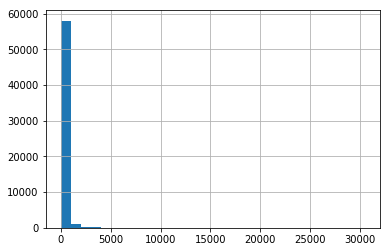

In [9]:
df["population"].hist(bins=30);

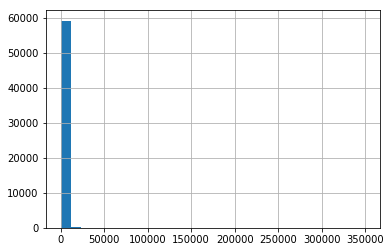

In [10]:
df["amount_tsh"].hist(bins=30);

#### 2: how many rows are there in each class/label?

In [11]:
df["status_group"].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

#### 3: Do a train-test split. What is the make-up of the labels in your train and test sets?

In [12]:
# first, deal with categorical values
df["source"].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [13]:
# drop unknown water source
df = df[df["source"] != "unknown"]

In [14]:
df["water_quality"].value_counts()

soft                  50781
salty                  4849
unknown                1855
milky                   803
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [15]:
# drop unknown water quality
df = df[df["water_quality"] != "unknown"]

In [16]:
# get dummy variables
X = pd.get_dummies(df[columns_of_interest], columns=['source', 'water_quality'], drop_first=True)
y = df["status_group"]
X.head()

,population,amount_tsh,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft
0,109,6000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,280,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,250,25.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,58,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


Some rows have 0 population?

In [17]:
print(len(X), len(X[X["population"] == 0]))

57479 20736


But the column says "population around the well" which might just mean the well is far from a populated area. We'll leave zeros in.

Do the train-test split:

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=44)

In [19]:
y_train.value_counts() / len(y_train)

functional                 0.556953
non functional             0.368585
functional needs repair    0.074463
Name: status_group, dtype: float64

In [20]:
y_test.value_counts() / len(y_test)

functional                 0.554860
non functional             0.370796
functional needs repair    0.074345
Name: status_group, dtype: float64

#### 4: Using your training set, obtain a basic KNN model's cross-validated accuracy

In [21]:
scores = cross_val_score(KNeighborsClassifier(),
                         X_train,
                         y_train,
                         scoring="accuracy",
                         cv=3)

In [22]:
import numpy as np

np.mean(scores)

0.5490992511578936

#### 5: Look at the confusion matrix: where are the mistakes?

`cross_val_score` doesn't give us a predictor, so you may have to train one!

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

knn = KNeighborsClassifier()

# do another train-test split so we can "peek"
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.3,
                                                      random_state=44)
knn.fit(X_train_2, y_train_2)

y_pred = knn.predict(X_val)

print(accuracy_score(y_val, y_pred))

confusion_matrix(y_val, y_pred)

0.5687184160384392


array([[5394,   58, 1178],
       [ 774,   21,  176],
       [2990,   30, 1450]])

Too many things are being predicted the majority class - not surprising as it's the majority of points!